In [1]:
!pip3 install kaggle streamlit

In [2]:
#!pip uninstall -y matplotlib numpy
!pip3 install --no-cache-dir matplotlib==3.8.0 numpy==1.23.5

In [3]:
import kagglehub
import pandas as pd
import os
import pickle
import streamlit as st
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib._api.deprecation
matplotlib._api.deprecation.mplDeprecation = DeprecationWarning

In [5]:
# Download Zillow dataset
path = kagglehub.dataset_download("zillow/zecon")
data_path = os.path.join(path, "State_time_series.csv")

df = pd.read_csv(data_path)
print("Available columns:", df.columns.tolist())
print("First 5 rows:\n", df.head())
print("Unique RegionNames:", df['RegionName'].unique().tolist())


100%|██████████| 511M/511M [00:09<00:00, 54.5MB/s]

Extracting files...


Available columns: ['Date', 'RegionName', 'DaysOnZillow_AllHomes', 'InventorySeasonallyAdjusted_AllHomes', 'InventoryRaw_AllHomes', 'MedianListingPricePerSqft_1Bedroom', 'MedianListingPricePerSqft_2Bedroom', 'MedianListingPricePerSqft_3Bedroom', 'MedianListingPricePerSqft_4Bedroom', 'MedianListingPricePerSqft_5BedroomOrMore', 'MedianListingPricePerSqft_AllHomes', 'MedianListingPricePerSqft_CondoCoop', 'MedianListingPricePerSqft_DuplexTriplex', 'MedianListingPricePerSqft_SingleFamilyResidence', 'MedianListingPrice_1Bedroom', 'MedianListingPrice_2Bedroom', 'MedianListingPrice_3Bedroom', 'MedianListingPrice_4Bedroom', 'MedianListingPrice_5BedroomOrMore', 'MedianListingPrice_AllHomes', 'MedianListingPrice_CondoCoop', 'MedianListingPrice_DuplexTriplex', 'MedianListingPrice_SingleFamilyResidence', 'MedianPctOfPriceReduction_AllHomes', 'MedianPctOfPriceReduction_CondoCoop', 'MedianPctOfPriceReduction_SingleFamilyResidence', 'MedianPriceCutDollar_AllHomes', 'MedianPriceCutDollar_CondoCoop', 'M

In [6]:
# Format the file path for Snowflake PUT command
snowflake_file_path = f"file://{data_path}"

print(f"PUT {snowflake_file_path} @my_stage;")

PUT file:///root/.cache/kagglehub/datasets/zillow/zecon/versions/6/State_time_series.csv @my_stage;


In [7]:
import os

file_path = '/root/.cache/kagglehub/datasets/zillow/zecon/versions/6/State_time_series.csv'
print(f"File exists: {os.path.exists(file_path)}")

File exists: True


In [8]:
# Ensure correct state naming
states = ['DistrictofColumbia', 'Maryland', 'Virginia']
models = {}


In [9]:
for state in states:
    state_df = df[df['RegionName'] == state][['Date', 'Sale_Prices']].dropna()
    if state_df.empty:
        print(f"No data for {state}")
        continue

    state_df['Date'] = pd.to_datetime(state_df['Date'])
    state_df = state_df.sort_values('Date')
    state_df['LagPrice'] = state_df['Sale_Prices'].shift(1)

    train = state_df.iloc[:-12]
    test = state_df.iloc[-12:]

    if train.empty or test.empty:
        print(f"Not enough data for {state}")
        continue

    X_train, y_train = train[['LagPrice']].fillna(train['LagPrice'].mean()), train['Sale_Prices']
    X_test, y_test = test[['LagPrice']].fillna(test['LagPrice'].mean()), test['Sale_Prices']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    mse = mean_squared_error(y_test, model.predict(X_test))
    print(f"{state} MSE: ${mse:,.2f}")
    models[state] = model
    state_df.to_csv(f"{state.replace(' ', '_')}_history.csv", index=False)

#

DistrictofColumbia MSE: $71,792,168.33
Maryland MSE: $48,450,674.25
Virginia MSE: $24,848,677.27


In [10]:
# Save models
for state, model in models.items():
    filename = f"rf_model_{state.lower().replace(' ', '_')}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved model for {state} to {filename}")

Saved model for DistrictofColumbia to rf_model_districtofcolumbia.pkl
Saved model for Maryland to rf_model_maryland.pkl
Saved model for Virginia to rf_model_virginia.pkl


In [11]:
# Streamlit App
st.set_page_config(page_title="Zillow DMV Forecast", page_icon="🏡", layout="wide")
st.title("🏡 Zillow DMV Market Forecast")
st.markdown("### Predict Median Sale Prices in the DMV Region!")
st.write("Forecast housing prices for D.C., Maryland, and Virginia with Zillow data.")



2025-03-26 00:03:39.858 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:39.860 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.023 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-26 00:03:40.036 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [12]:
# Load history
data_file = f"{state.replace(' ', '_')}_history.csv"
try:
    history_df = pd.read_csv(data_file)
    history_df['Date'] = pd.to_datetime(history_df['Date'])
except FileNotFoundError:
    st.warning(f"History file '{data_file}' not found. Historical trend unavailable.")
    history_df = pd.DataFrame()

# Input
st.subheader("Set Your Input")
lag_price = st.slider(
    "Last Month’s Median Sale Price ($)",
    min_value=int(history_df['Sale_Prices'].min()) if not history_df.empty else 100000,
    max_value=int(history_df['Sale_Prices'].max()) if not history_df.empty else 1500000,
    value=int(history_df['Sale_Prices'].iloc[-1]) if not history_df.empty else 500000,
    step=10000,
    format="$%d"
)

# Prediction
input_data = pd.DataFrame([[lag_price]], columns=['LagPrice'])
prediction = model.predict(input_data)[0]
conf_low, conf_high = prediction * 0.9, prediction * 1.1

# Display forecast
st.subheader("Forecast Result")
col1, col2 = st.columns(2)
with col1:
    st.metric("Last Month", f"${lag_price:,.0f}")
with col2:
    st.metric("Next Month Prediction", f"${prediction:,.0f}", delta=f"${prediction - lag_price:,.0f}")
st.write(f"Confidence Range: ${conf_low:,.0f} - ${conf_high:,.0f}")


2025-03-26 00:03:40.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:40.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [13]:
!pip3 install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


2025-03-26 00:03:56.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.537 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03:56.544 Session state does not function when running a script without `streamlit run`
2025-03-26 00:03:56.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:03

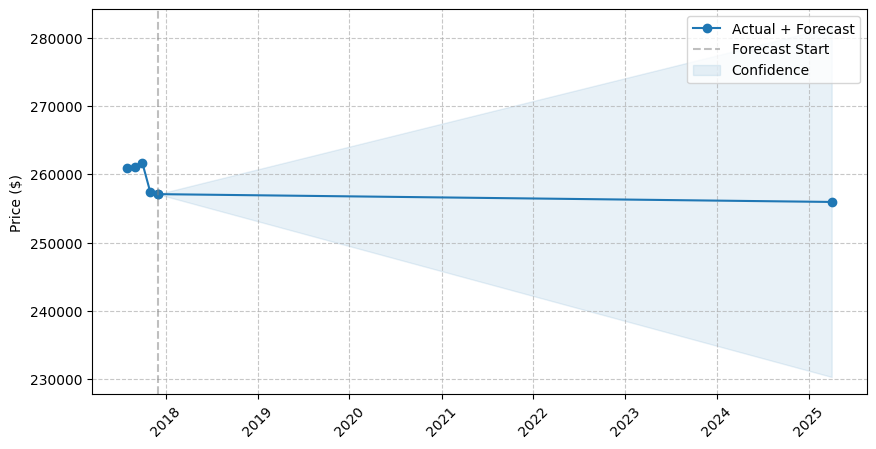

In [14]:
# Historical trend

st.sidebar.header("DMV Options")
available_states = ["Maryland", "Virginia", "District of Columbia"]
state = st.sidebar.selectbox("Select DMV Area", available_states, index=0)
show_history = st.sidebar.checkbox("Show Historical Trend", value=True)  # <--- Ensure this exists'

if show_history and not history_df.empty:
    st.subheader(f"{state} Price Trend")
    plot_df = pd.concat([
        history_df.tail(5),
        pd.DataFrame({'Date': [history_df['Date'].iloc[-1], pd.Timestamp('2025-04-01')], 'Sale_Prices': [lag_price, prediction]})
    ])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(plot_df['Date'], plot_df['Sale_Prices'], marker='o', color='#1f77b4', label='Actual + Forecast')
    ax.axvline(history_df['Date'].iloc[-1], color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
    ax.fill_between([plot_df['Date'].iloc[-2], plot_df['Date'].iloc[-1]], [lag_price, conf_low], [lag_price, conf_high], color='#1f77b4', alpha=0.1, label='Confidence')
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    st.pyplot(fig)

st.markdown("---")
st.write("✨ Forecast generated on March 14, 2025. Data from Zillow via kagglehub.")


In [15]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

# Streamlit App
st.set_page_config(page_title="Zillow DMV Forecast", page_icon="🏡", layout="wide")
st.title("🏡 Zillow DMV Market Forecast")
st.markdown("### Predict Median Sale Prices in the DMV Region!")
st.write("Forecast housing prices for D.C., Maryland, and Virginia with Zillow data.")

# Sidebar
st.sidebar.header("DMV Options")
available_states = ["District of Columbia", "Maryland", "Virginia"]
state = st.sidebar.selectbox("Select DMV Area", available_states, index=0)
show_history = st.sidebar.checkbox("Show Historical Trend", value=True)
use_model = st.sidebar.checkbox("Use Local Model Instead of Snowflake", value=False)
# Load model
state_key = state.replace(" ", "").lower()  # Remove spaces and lowercase it
model_file = f"rf_model_{state_key}.pkl"

if os.path.exists(model_file):
    with open(model_file, "rb") as f:
        model = pickle.load(f)
    st.write(f"✅ Loaded model for {state}")
else:
    st.error(f"Model file '{model_file}' not found. Please add it to the folder.")
    st.stop()

# Load history
data_file = f"{state.replace(' ', '')}_history.csv"  # Remove spaces in the state name for the file
try:
    history_df = pd.read_csv(data_file)
    history_df['Date'] = pd.to_datetime(history_df['Date'])
except FileNotFoundError:
    st.warning(f"History file '{data_file}' not found. Historical trend unavailable.")
    history_df = pd.DataFrame()

# Input
st.subheader("Set Your Input")
lag_price = st.slider(
    "Last Month’s Median Sale Price ($)",
    min_value=int(history_df['Sale_Prices'].min()) if not history_df.empty else 100000,
    max_value=int(history_df['Sale_Prices'].max()) if not history_df.empty else 1500000,
    value=int(history_df['Sale_Prices'].iloc[-1]) if not history_df.empty else 500000,
    step=10000,
    format="$%d"
)

# Prediction
input_data = pd.DataFrame([[lag_price]], columns=['LagPrice'])
prediction = model.predict(input_data)[0]
conf_low, conf_high = prediction * 0.9, prediction * 1.1

# Display forecast
st.subheader("Forecast Result")
col1, col2 = st.columns(2)
with col1:
    st.metric("Last Month", f"${lag_price:,.0f}")
with col2:
    st.metric("Next Month Prediction", f"${prediction:,.0f}", delta=f"${prediction - lag_price:,.0f}")
st.write(f"Confidence Range: ${conf_low:,.0f} - ${conf_high:,.0f}")

# Historical trend
if show_history and not history_df.empty:
    st.subheader(f"{state} Price Trend")
    plot_df = pd.concat([
        history_df.tail(5),
        pd.DataFrame({'Date': [history_df['Date'].iloc[-1], pd.Timestamp('2025-04-01')], 'Sale_Prices': [lag_price, prediction]})
    ])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(plot_df['Date'], plot_df['Sale_Prices'], marker='o', color='#1f77b4', label='Actual + Forecast')
    ax.axvline(history_df['Date'].iloc[-1], color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
    ax.fill_between([plot_df['Date'].iloc[-2], plot_df['Date'].iloc[-1]], [lag_price, conf_low], [lag_price, conf_high], color='#1f77b4', alpha=0.1, label='Confidence')
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    st.pyplot(fig)

st.markdown("---")
st.write("✨ Forecast generated on March 14, 2025. Data from Zillow via kagglehub.")
""")

In [16]:
import matplotlib._api.deprecation
matplotlib._api.deprecation.mplDeprecation = DeprecationWarning

In [17]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [18]:
!wget -q -O - https://loca.lt/mytunnelpassword

35.227.19.93

In [19]:
import matplotlib._api.deprecation
matplotlib._api.deprecation.mplDeprecation = DeprecationWarning

In [20]:
from google.colab import files
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#34.106.229.127

In [22]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.19.93:8501

⠙⠹⠸⠼⠴⠦⠧⠇Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇your url is: https://empty-adults-mate.loca.lt
  Stopping...
^C


In [23]:
!pip install snowflake-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 6.6 MB/s eta 0:00:00


In [24]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("zillow/zecon")
data_path = f"{path}/State_time_series.csv"

if os.path.exists(data_path):
    print(f"File found at: {data_path}")
else:
    print("File not found!")
    raise FileNotFoundError(data_path)

File found at: /root/.cache/kagglehub/datasets/zillow/zecon/versions/6/State_time_series.csv


In [25]:
!pip install -U kagglehub snowflake-connector-python pandas

import kagglehub
import snowflake.connector
import os
import pandas as pd







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [26]:
# Snowflake connection
conn = snowflake.connector.connect(
    user='TNEWSOME',
    password='sywXud-pucso5-pohgar',
    account='XOJMCUN-QF26830',
    warehouse='COMPUTE_WH',
    database='zillow_data',
    schema='zillow_data'
)

cur = conn.cursor()

# Fetch dataset
path = kagglehub.dataset_download("zillow/zecon")
data_path = f"{path}/State_time_series.csv"
print(f"File path: {data_path}")

# Local preview
df_local = pd.read_csv(data_path, nrows=10)
print("Local preview (first 10 rows):")
print(df_local)

# Setup
cur.execute("CREATE DATABASE IF NOT EXISTS zillow_data")
cur.execute("USE DATABASE zillow_data")
cur.execute("CREATE SCHEMA IF NOT EXISTS zillow_data")
cur.execute("USE SCHEMA zillow_data")
cur.execute("""
    CREATE OR REPLACE STAGE my_stage
    FILE_FORMAT = (TYPE = CSV FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1)
""")
cur.execute("""
    CREATE OR REPLACE TABLE zillow_housing_data (
        Date DATE,
        RegionName STRING,
        Sale_Prices FLOAT,
        InventoryAll FLOAT,
        ZHVI_AllHomes FLOAT
    )
""")

# Upload
cur.execute(f"PUT file://{data_path} @my_stage AUTO_COMPRESS=TRUE")
cur.execute("LIST @my_stage")
print("Files in stage:", cur.fetchall())

# Load with column mapping
cur.execute("""
    COPY INTO zillow_housing_data (Date, RegionName, Sale_Prices, InventoryAll, ZHVI_AllHomes)
    FROM (
        SELECT $1, $2, $54, $62, $67
        FROM @my_stage/State_time_series.csv.gz
    )
    FILE_FORMAT = (TYPE = CSV FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1)
    ON_ERROR = 'CONTINUE'
""")

# Verify
cur.execute("SELECT * FROM zillow_housing_data LIMIT 10")
rows = cur.fetchall()
print("First 10 rows:", rows)
cur.execute("SELECT COUNT(*) FROM zillow_housing_data")
count = cur.fetchone()[0]
print(f"Total rows: {count}")

cur.close()
conn.close()

File path: /root/.cache/kagglehub/datasets/zillow/zecon/versions/6/State_time_series.csv
Local preview (first 10 rows):
         Date   RegionName  DaysOnZillow_AllHomes  \
0  1996-04-30      Alabama                    NaN   
1  1996-04-30      Arizona                    NaN   
2  1996-04-30     Arkansas                    NaN   
3  1996-04-30   California                    NaN   
4  1996-04-30     Colorado                    NaN   
5  1996-04-30  Connecticut                    NaN   
6  1996-04-30     Delaware                    NaN   
7  1996-04-30      Florida                    NaN   
8  1996-04-30      Georgia                    NaN   
9  1996-04-30       Hawaii                    NaN   

   InventorySeasonallyAdjusted_AllHomes  InventoryRaw_AllHomes  \
0                                   NaN                    NaN   
1                                   NaN                    NaN   
2                                   NaN                    NaN   
3                               

In [27]:

try:
    cur.execute("SELECT CURRENT_DATE")
    result = cur.fetchone()
    print(f"Connected to Snowflake! Current date is: {result[0]}")
except Exception as e:
    print(f"Error connecting to Snowflake: {e}")


Error connecting to Snowflake: 252006: Cursor is closed in execute.


In [28]:
import streamlit as st
import pandas as pd
import snowflake.connector

# Snowflake connection
try:
    conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse='COMPUTE_WH',
    database='zillow_data',
    schema='zillow_data'
    )
except Exception as e:
    st.error(f"Snowflake connection failed: {e}")
    st.stop()

st.set_page_config(page_title="Zillow DMV Forecast", page_icon="🏡", layout="wide")
st.title("🏡 Zillow DMV Market Forecast")
st.markdown("### Predict Median Sale Prices in Maryland & Virginia!")

state = st.sidebar.selectbox("Select DMV Area", ["Maryland", "Virginia"], index=0)

# Fetch data
query = f"""
    SELECT "Date" AS sale_date, "Sale_Prices" AS sale_price,
           LAG("Sale_Prices") OVER (PARTITION BY "RegionName" ORDER BY "Date") AS lag_price
    FROM zillow_housing_data
    WHERE "RegionName" = '{state}'
    ORDER BY sale_date DESC
    LIMIT 1
"""
try:
    df = pd.read_sql(query, conn)
    if df.empty:
        st.warning(f"No data found for {state}")
        lag_price = 500000
        predicted = lag_price
    else:
        # Show column names
        st.write("Columns in DataFrame:", df.columns.tolist())
        # Check if lag_price exists and is not null
        lag_price = int(df['lag_price'].iloc[0]) if 'lag_price' in df.columns and not pd.isna(df['lag_price'].iloc[0]) else 500000
        sale_price = df['sale_price'].iloc[0] if 'sale_price' in df.columns and not pd.isna(df['sale_price'].iloc[0]) else lag_price
        predicted = lag_price + (sale_price - lag_price) * 0.1 if not df.empty else lag_price
except Exception as e:
    st.error(f"Query failed: {e}")
    conn.close()
    st.stop()



2025-03-26 00:10:14.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-26 00:10:14.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [29]:
#

In [30]:
import os
print(os.listdir())

['.config', 'rf_model_virginia.pkl', 'app.py', 'DistrictofColumbia_history.csv', 'Maryland_history.csv', 'rf_model_maryland.pkl', 'Virginia_history.csv', 'rf_model_districtofcolumbia.pkl', 'sample_data']


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.19.93:8501



In [ ]:
import streamlit as st
import pandas as pd
import snowflake.connector

# Snowflake connection
try:
    conn = snowflake.connector.connect(
        user='TNEWSOME',
        password='sywXud-pucso5-pohgar',
        account='XOJMCUN-QF26830',
        warehouse='COMPUTE_WH',
        database='zillow_data',
        schema='zillow_data'
    )
except Exception as e:
    st.error(f"Snowflake connection failed: {e}")
    st.stop()

st.set_page_config(page_title="Zillow DMV Forecast", page_icon="🏡", layout="wide")
st.title("🏡 Zillow DMV Market Forecast")
st.markdown("### Predict Median Sale Prices in Maryland & Virginia!")

state = st.sidebar.selectbox("Select DMV Area", ["Maryland", "Virginia"], index=0)

# Default values
lag_price = 500000
predicted = 500000

# Fetch data
query = f"""
    WITH PriceTrends AS (
        SELECT "RegionName",
               DATE_TRUNC('month', "Date") AS Month,
               AVG("Sale_Prices") AS Avg_Sale_Price
        FROM zillow_housing_data
        WHERE "RegionName" = '{state}'
        GROUP BY "RegionName", Month
    )
    SELECT Month AS sale_date,
           Avg_Sale_Price AS sale_price,
           LAG(Avg_Sale_Price) OVER (PARTITION BY "RegionName" ORDER BY Month) AS lag_price
    FROM PriceTrends
    ORDER BY sale_date DESC
    LIMIT 1
"""
try:
    df = pd.read_sql(query, conn)
    if df.empty:
        st.warning(f"No data found for {state}")
    else:
        st.write("Columns in DataFrame:", df.columns.tolist())
        lag_price = int(df['lag_price'].iloc[0]) if 'lag_price' in df.columns and not pd.isna(df['lag_price'].iloc[0]) else 500000
        sale_price = df['sale_price'].iloc[0] if 'sale_price' in df.columns and not pd.isna(df['sale_price'].iloc[0]) else lag_price
        predicted = lag_price + (sale_price - lag_price) * 0.1
except Exception as e:
    st.error(f"Query failed: {e}")
    conn.close()
    st.stop()

# Input
lag_price = st.slider(
    "Last Month’s Median Sale Price ($)",
    min_value=100000,
    max_value=1500000,
    value=lag_price,
    step=10000,
    format="$%d"
)

# Display
st.subheader("Forecast Result")
col1, col2 = st.columns(2)
with col1:
    st.metric("Last Month", f"${lag_price:,.0f}")
with col2:
    st.metric("Next Month Prediction", f"${predicted:,.0f}", delta=f"${predicted - lag_price:,.0f}")

st.write("Latest Data from Snowflake:", df)
conn.close()

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501